In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## Reading the dataset

In [ ]:
edata = pd.read_csv('ecommerce_data.csv')

## Exploratory Data Analysis

In [ ]:
edata.columns

In [ ]:
edata.describe()

How can quantity and UnitPrice be negative? - Because they are cancelled orders

In [ ]:
edata.isnull().values.any()

In [ ]:
edata['CustomerID'].isnull().sum()

## Remove null values from customerId

Since CustomerId is an important variable and having NA values for customerId is of no value. Also, we cannot impute because it is beyond 10% missing. Hence I am dropping the null values for customerId

In [ ]:
edata = edata[edata['CustomerID'].notna()]

## Remove cancelled orders

In [ ]:
edata = edata[edata['Quantity'] > 0]

## Convert InvoiceDate from Date to String

In [ ]:
edata['InvoiceDate'] = pd.to_datetime(edata['InvoiceDate'])

In [ ]:
sns.distplot(edata['Quantity']);

In [ ]:
sns.distplot(edata['UnitPrice']);

#### Which country is ordering the most quantity?

In [ ]:
var = 'Country'
data = pd.concat([edata['Quantity'], edata[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Quantity", data=data)
fig.axis(ymin=0, ymax=100);
plt.xticks(rotation=90);

#### Which channel drives the sales the most?

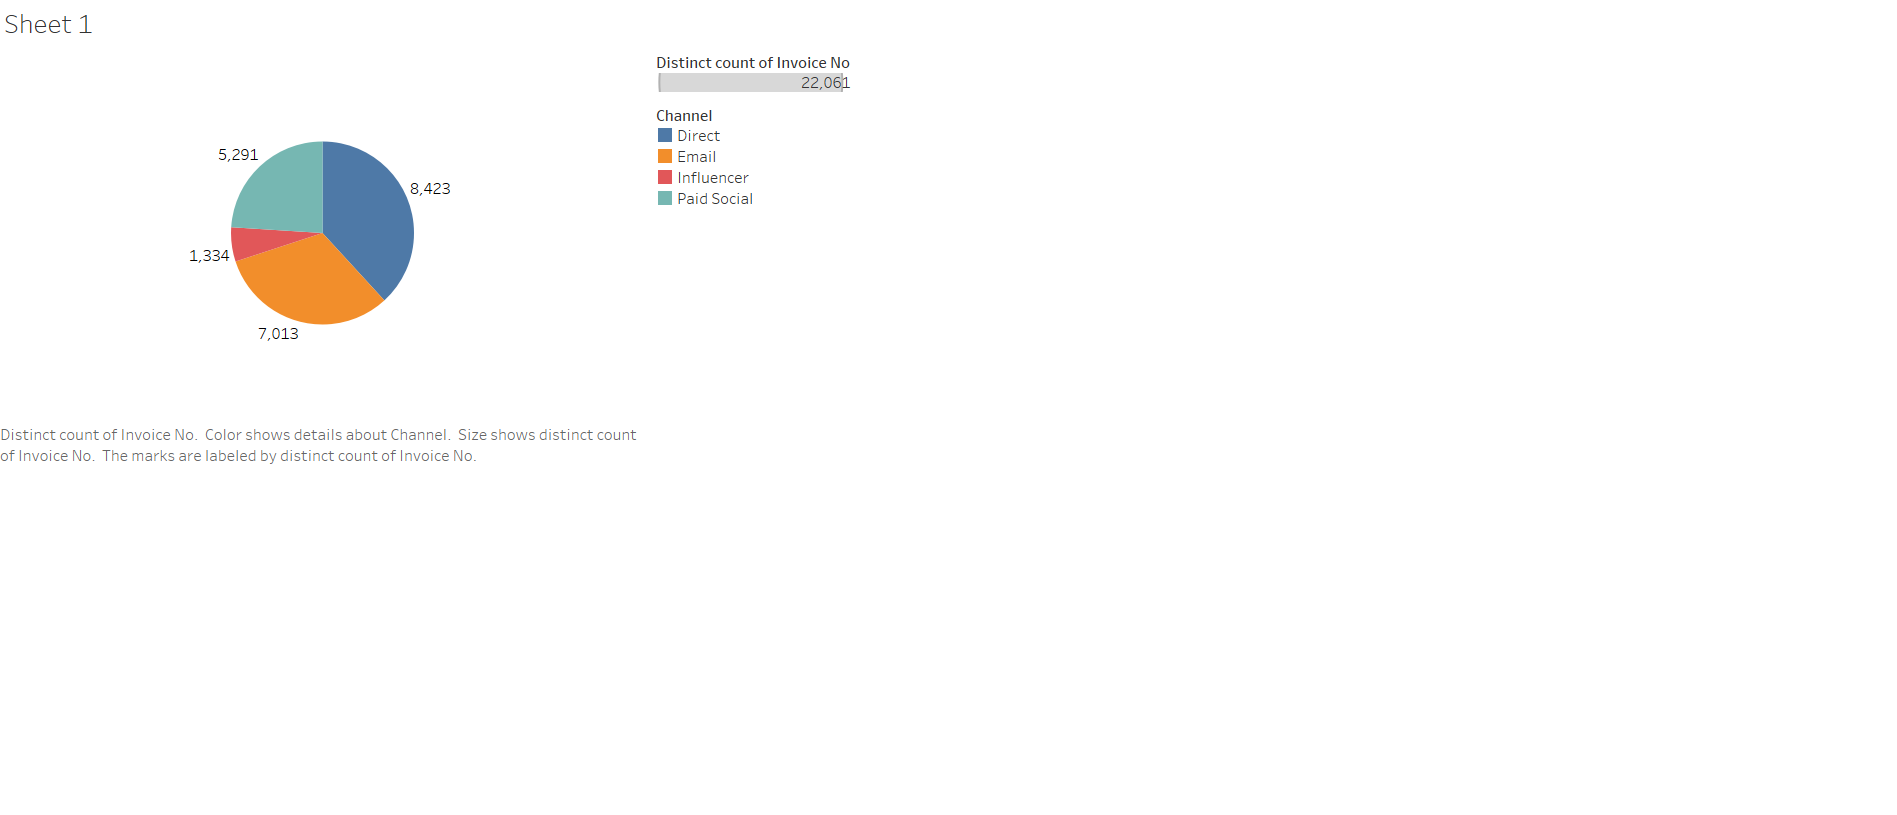


# Prediction

## Extract first 6 months to create features for train

In [ ]:
max_date = edata['InvoiceDate'].max()

In [ ]:
end = max_date - timedelta(days=180)

In [ ]:
train_features = edata[edata['InvoiceDate'] < end]

In [ ]:
train_features

## Create features for train

### 1. Purchase frequency of a customer (overall how many times the customer made a purchase)

In [ ]:
target_train1 = train_features[['CustomerID', 'InvoiceNo']]

In [ ]:
grouped_df = target_train1.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceNo": "nunique"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"InvoiceNo": "purchase_frequency"})
grouped_df

### 2. frequency of customer purchasing atleast once in 3 months

In [ ]:
target_train2 = train_features[['CustomerID', 'InvoiceDate']]

In [ ]:
def purchase_recency(invoiceDateList):
    x = 0
    for i in range(len(invoiceDateList)):
        if (i + 1) < len(invoiceDateList):
            diff = (invoiceDateList[i+1] - invoiceDateList[i]).days
            if diff < 92:
                x = x + 1
    return x             

In [ ]:
target_train2['InvoiceDate'] = pd.to_datetime(target_train2['InvoiceDate']).apply(lambda x: x.date())
target_train2 = target_train2.sort_values(['InvoiceDate'],ascending=False).groupby('CustomerID').agg({'InvoiceDate':'unique'}).reset_index()
target_train2['purchase_recency'] = target_train2['InvoiceDate'].apply(lambda x: purchase_recency(x))
target_train2

In [ ]:
target_final = pd.merge(grouped_df, target_train2[['CustomerID', 'purchase_recency']])
target_final['recency_percentage'] = round(target_final['purchase_recency']/target_final['purchase_frequency'] * 100)
target_final

### 3. Total amount spent and average amount spent

In [ ]:
train3 = train_features[['CustomerID', 'InvoiceNo', 'UnitPrice']]

In [ ]:
grouped_df = train3.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceNo": "nunique", "UnitPrice": "sum"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"UnitPrice": "TotalPrice", "InvoiceNo": "purchase_frequency"})
grouped_df['AvgPrice'] = grouped_df['TotalPrice']/grouped_df['purchase_frequency']

In [ ]:
target_final = pd.merge(target_final, grouped_df)
target_final

### 4. Average no of unique stock codes

In [ ]:
train4 = train_features[['CustomerID', 'StockCode']]

In [ ]:
grouped_df = train4.groupby("CustomerID")
grouped_df = grouped_df. agg({"StockCode": "nunique"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"StockCode": "StockCode_freq"})

In [ ]:
target_final = pd.merge(target_final, grouped_df)
target_final['Avg_StockCode_freq'] = round(target_final['StockCode_freq']/target_final['purchase_frequency'])
target_final

###  5. No. of purchases in recent most 1 month, 2 months, 3 months, 6 months

In [ ]:
train5 = train_features[['CustomerID', 'InvoiceDate']]

In [ ]:
# for 1 month
max_train_date = train5['InvoiceDate'].max()
recent_x_month = max_train_date - timedelta(days=30)
train5_filtered = train5[train5['InvoiceDate'] >= recent_x_month]
grouped_df = train5_filtered.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceDate": "nunique"})
grouped_df = grouped_df. reset_index()
grouped_df = grouped_df.rename(columns={"InvoiceDate": "recent_1_month_freq"})

In [ ]:
#for 2 months
recent_x_month = max_train_date - timedelta(days=60)
train5_filtered = train5[train5['InvoiceDate'] >= recent_x_month]
grouped_df_2 = train5_filtered.groupby("CustomerID")
grouped_df_2 = grouped_df_2. agg({"InvoiceDate": "nunique"})
grouped_df_2 = grouped_df_2. reset_index()
grouped_df_2 = grouped_df_2.rename(columns={"InvoiceDate": "recent_2_month_freq"})

In [ ]:
#for 3 months
recent_x_month = max_train_date - timedelta(days=90)
train5_filtered = train5[train5['InvoiceDate'] >= recent_x_month]
grouped_df_3 = train5_filtered.groupby("CustomerID")
grouped_df_3 = grouped_df_3. agg({"InvoiceDate": "nunique"})
grouped_df_3 = grouped_df_3. reset_index()
grouped_df_3 = grouped_df_3.rename(columns={"InvoiceDate": "recent_3_month_freq"})

In [ ]:
#for 6 months
recent_x_month = max_train_date - timedelta(days=180)
train5_filtered = train5[train5['InvoiceDate'] >= recent_x_month]
grouped_df_6 = train5_filtered.groupby("CustomerID")
grouped_df_6 = grouped_df_6. agg({"InvoiceDate": "nunique"})
grouped_df_6 = grouped_df_6. reset_index()
grouped_df_6 = grouped_df_6.rename(columns={"InvoiceDate": "recent_6_month_freq"})

In [ ]:
df_train_final = target_final.merge(grouped_df, on = 'CustomerID', how = 'left')

In [ ]:
df_train_final = df_train_final.merge(grouped_df_2, on = 'CustomerID', how = 'left')
df_train_final = df_train_final.merge(grouped_df_3, on = 'CustomerID', how = 'left')
df_train_final = df_train_final.merge(grouped_df_6, on = 'CustomerID', how = 'left')

In [ ]:
df_train_final['recent_1_month_freq'] = df_train_final['recent_1_month_freq'].fillna(0)
df_train_final['recent_2_month_freq'] = df_train_final['recent_2_month_freq'].fillna(0)
df_train_final['recent_3_month_freq'] = df_train_final['recent_3_month_freq'].fillna(0)
df_train_final['recent_6_month_freq'] = df_train_final['recent_6_month_freq'].fillna(0)

In [ ]:
df_train_final

## Train data for training from 7 - 9 month

In [ ]:
min_date = train_features['InvoiceDate'].max()

In [ ]:
end = min_date + timedelta(days=90)

In [ ]:
train = edata[(edata['InvoiceDate'] > min_date) & (edata['InvoiceDate'] < end)]

In [ ]:
# Target variable should be created only for those customers who are in train_features
customers_train_features = df_train_final.CustomerID
train = train[train['CustomerID'].isin(customers_train_features)]

In [ ]:
train_target = train[['CustomerID', 'InvoiceDate']]
train_target['InvoiceDate'] = pd.to_datetime(train_target['InvoiceDate']).apply(lambda x: x.date())
train_target = train_target.sort_values(['InvoiceDate'],ascending=False).groupby('CustomerID').agg({'InvoiceDate':'unique'}).reset_index()
train_target

In [ ]:
#If customer is in train then target variable is 1 else 0
def customer_recency(customerId):
    customers_train = train.CustomerID.unique()
    #print(customers_train)
    x = 0
    for i in customers_train:
        if customerId == i:
            x = 1
    return x

In [ ]:
df_train_final['customer_recency_binary'] = df_train_final['CustomerID'].apply(lambda x: customer_recency(x))

In [ ]:
df_train_final

### Mode of Country, channel

In [ ]:
train_target7 = train_features[['CustomerID', 'Country']]

In [ ]:
#train_target7.groupby(['CustomerID','Country']).agg(lambda x:x.value_counts().index[0])

train_target7 = train_target7.groupby(['CustomerID'])['Country'].agg(
    lambda x: pd.Series.mode(x)[0])

train_target7 = train_target7.to_frame()

In [ ]:
df_train_final = pd.merge(df_train_final, train_target7, on = 'CustomerID')

In [ ]:
df_train_final

In [ ]:
train_target8 = train_features[['CustomerID', 'channel']]

In [ ]:
train_target8 = train_target8.groupby(['CustomerID'])['channel'].agg(
    lambda x: pd.Series.mode(x)[0])

train_target8 = train_target8.to_frame()

In [ ]:
df_train_final = pd.merge(df_train_final, train_target8, on = 'CustomerID')

In [ ]:
df_train_final

## Extract 4 - 9 months to create features for test

In [ ]:
max_date = edata['InvoiceDate'].max()

In [ ]:
end = max_date - timedelta(days=90)

In [ ]:
start = end - timedelta(days=180)

In [ ]:
test_features = edata[(edata['InvoiceDate'] > start) & (edata['InvoiceDate'] < end)]

## Create features for test

### 1. Purchase frequency of a customer (overall how many times the customer made a purchase)

In [ ]:
target_test1 = test_features[['CustomerID', 'InvoiceNo']]

In [ ]:
grouped_df = target_test1.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceNo": "nunique"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"InvoiceNo": "purchase_frequency"})
grouped_df

### 2. frequency of customer purchasing atleast once in 3 months

In [ ]:
target_test2 = test_features[['CustomerID', 'InvoiceDate']]

In [ ]:
def purchase_recency(invoiceDateList):
    x = 0
    for i in range(len(invoiceDateList)):
        if (i + 1) < len(invoiceDateList):
            diff = (invoiceDateList[i+1] - invoiceDateList[i]).days
            if diff < 92:
                x = x + 1
    return x             

In [ ]:
target_test2['InvoiceDate'] = pd.to_datetime(target_test2['InvoiceDate']).apply(lambda x: x.date())
target_test2 = target_test2.sort_values(['InvoiceDate'],ascending=False).groupby('CustomerID').agg({'InvoiceDate':'unique'}).reset_index()
target_test2['purchase_recency'] = target_test2['InvoiceDate'].apply(lambda x: purchase_recency(x))
target_test2

In [ ]:
target_final = pd.merge(grouped_df, target_test2[['CustomerID', 'purchase_recency']])
target_final['recency_percentage'] = round(target_final['purchase_recency']/target_final['purchase_frequency'] * 100)
target_final

### 3. Total amount spent and average amount spent

In [ ]:
test3 = test_features[['CustomerID', 'InvoiceNo', 'UnitPrice']]

In [ ]:
grouped_df = test3.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceNo": "nunique", "UnitPrice": "sum"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"UnitPrice": "TotalPrice", "InvoiceNo": "purchase_frequency"})
grouped_df['AvgPrice'] = grouped_df['TotalPrice']/grouped_df['purchase_frequency']

In [ ]:
target_final = pd.merge(target_final, grouped_df)
target_final

### 4. Average no of unique stock codes

In [ ]:
test4 = test_features[['CustomerID', 'StockCode']]

In [ ]:
grouped_df = test4.groupby("CustomerID")
grouped_df = grouped_df. agg({"StockCode": "nunique"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"StockCode": "StockCode_freq"})

In [ ]:
target_final = pd.merge(target_final, grouped_df)
target_final['Avg_StockCode_freq'] = round(target_final['StockCode_freq']/target_final['purchase_frequency'])
target_final

###  5. No. of purchases in recent most 1 month, 2 months, 3 months, 6 months

In [ ]:
test5 = test_features[['CustomerID', 'InvoiceDate']]

In [ ]:
# for 1 month
max_test_date = test5['InvoiceDate'].max()
recent_x_month = max_test_date - timedelta(days=30)
test5_filtered = test5[test5['InvoiceDate'] >= recent_x_month]
grouped_df = test5_filtered.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceDate": "nunique"})
grouped_df = grouped_df. reset_index()
grouped_df = grouped_df.rename(columns={"InvoiceDate": "recent_1_month_freq"})

In [ ]:
#for 2 months
recent_x_month = max_test_date - timedelta(days=60)
train5_filtered = test5[test5['InvoiceDate'] >= recent_x_month]
grouped_df_2 = train5_filtered.groupby("CustomerID")
grouped_df_2 = grouped_df_2. agg({"InvoiceDate": "nunique"})
grouped_df_2 = grouped_df_2. reset_index()
grouped_df_2 = grouped_df_2.rename(columns={"InvoiceDate": "recent_2_month_freq"})

In [ ]:
#for 3 months
recent_x_month = max_test_date - timedelta(days=90)
test5_filtered = test5[test5['InvoiceDate'] >= recent_x_month]
grouped_df_3 = test5_filtered.groupby("CustomerID")
grouped_df_3 = grouped_df_3. agg({"InvoiceDate": "nunique"})
grouped_df_3 = grouped_df_3. reset_index()
grouped_df_3 = grouped_df_3.rename(columns={"InvoiceDate": "recent_3_month_freq"})

In [ ]:
#for 6 months
recent_x_month = max_test_date - timedelta(days=180)
test5_filtered = test5[test5['InvoiceDate'] >= recent_x_month]
grouped_df_6 = test5_filtered.groupby("CustomerID")
grouped_df_6 = grouped_df_6. agg({"InvoiceDate": "nunique"})
grouped_df_6 = grouped_df_6. reset_index()
grouped_df_6 = grouped_df_6.rename(columns={"InvoiceDate": "recent_6_month_freq"})

In [ ]:
df_test_final = target_final.merge(grouped_df, on = 'CustomerID', how = 'left')

In [ ]:
df_test_final = df_test_final.merge(grouped_df_2, on = 'CustomerID', how = 'left')
df_test_final = df_test_final.merge(grouped_df_3, on = 'CustomerID', how = 'left')
df_test_final = df_test_final.merge(grouped_df_6, on = 'CustomerID', how = 'left')

In [ ]:
df_test_final['recent_1_month_freq'] = df_test_final['recent_1_month_freq'].fillna(0)
df_test_final['recent_2_month_freq'] = df_test_final['recent_2_month_freq'].fillna(0)
df_test_final['recent_3_month_freq'] = df_test_final['recent_3_month_freq'].fillna(0)
df_test_final['recent_6_month_freq'] = df_test_final['recent_6_month_freq'].fillna(0)

In [ ]:
df_test_final

## Test data from 10 - 12 month

In [ ]:
max_date = edata['InvoiceDate'].max()

In [ ]:
start = max_date - timedelta(days=90)

In [ ]:
test = edata[(edata['InvoiceDate'] > start) & (edata['InvoiceDate'] < max_date)]

In [ ]:
# Target variable should be created only for those customers who are in train_features
customers_test_features = df_test_final.CustomerID
test = test[test['CustomerID'].isin(customers_test_features)]

In [ ]:
test_target = test[['CustomerID', 'InvoiceDate']]
test_target['InvoiceDate'] = pd.to_datetime(test_target['InvoiceDate']).apply(lambda x: x.date())
test_target = test_target.sort_values(['InvoiceDate'],ascending=False).groupby('CustomerID').agg({'InvoiceDate':'unique'}).reset_index()
test_target

In [ ]:
#If customer is in train then target variable is 1 else 0
def customer_recency(customerId):
    customers_test = test.CustomerID.unique()
    #print(customers_train)
    x = 0
    for i in customers_test:
        if customerId == i:
            x = 1
    return x

In [ ]:
df_test_final['customer_recency_binary'] = df_test_final['CustomerID'].apply(lambda x: customer_recency(x))

### Mode for Country, channel

In [ ]:
test_target7 = test_features[['CustomerID', 'Country']]

In [ ]:
test_target7 = test_target7.groupby(['CustomerID'])['Country'].agg(
    lambda x: pd.Series.mode(x)[0])

test_target7 = test_target7.to_frame()

In [ ]:
df_test_final = pd.merge(df_test_final, test_target7, on = 'CustomerID')

In [ ]:
test_target8 = test_features[['CustomerID', 'channel']]

In [ ]:
test_target8 = test_target8.groupby(['CustomerID'])['channel'].agg(
    lambda x: pd.Series.mode(x)[0])

test_target8 = test_target8.to_frame()

In [ ]:
df_test_final = pd.merge(df_test_final, test_target8, on = 'CustomerID')

In [ ]:
df_test_final

In [ ]:
df_train_final.drop(columns = ['purchase_frequency', 'purchase_recency'], inplace = True)

In [ ]:
df_test_final.drop(columns = ['purchase_frequency', 'purchase_recency'], inplace = True)

### One hot encoding

In [ ]:
df_train_final = pd.get_dummies(df_train_final, columns = ['Country', 'channel'])
df_test_final = pd.get_dummies(df_test_final, columns = ['Country', 'channel'])

In [ ]:
df_train_final

In [ ]:
df_train_final.columns

In [ ]:
df_test_final.columns

In [ ]:
a = list(set(list(df_train_final.columns) + list(df_test_final.columns)))

In [ ]:
for i in a:
    if i not in df_train_final.columns:
        df_train_final[i] = 0
    if i not in df_test_final.columns:
        df_test_final[i] = 0

### Log transformation

In [ ]:
for i in df_train_final.columns:
    if i != 'customer_recency_binary':
        df_train_final[i] = np.log1p(df_train_final[i])

In [ ]:
for i in df_test_final.columns:
    if i != 'customer_recency_binary':
        df_test_final[i] = np.log1p(df_test_final[i])

## Model

In [ ]:
y_train = df_train_final.loc[:,'customer_recency_binary']
X_train = df_train_final.drop(columns = ['CustomerID', 'customer_recency_binary'])

In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_test = df_test_final.drop(columns = ['CustomerID', 'customer_recency_binary'])
y_test = df_test_final.loc[:,'customer_recency_binary']

In [ ]:
clf = GradientBoostingClassifier(random_state=0, n_estimators = 100, learning_rate = 0.01)
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

The accuracy of the model can still be improved by adding more required features.

## Clustering 

In [ ]:
clus_data = edata[['CustomerID', 'InvoiceNo', 'InvoiceDate', 'UnitPrice', 'StockCode']]

In [ ]:
grouped_df = clus_data.groupby("CustomerID")
grouped_df = grouped_df. agg({"InvoiceNo": "nunique", "UnitPrice": "sum", "StockCode": "nunique"})
grouped_df = grouped_df. reset_index()

In [ ]:
grouped_df = grouped_df.rename(columns={"UnitPrice": "TotalPrice", "InvoiceNo": "purchase_frequency", "StockCode": "StockCode_freq"})

In [ ]:
clus_data['InvoiceDate'] = pd.to_datetime(clus_data['InvoiceDate']).apply(lambda x: x.date())
clus_data = clus_data.sort_values(['InvoiceDate'],ascending=False).groupby('CustomerID').agg({'InvoiceDate':'unique'}).reset_index()
clus_data['purchase_recency'] = target_test2['InvoiceDate'].apply(lambda x: purchase_recency(x))
clus_data['purchase_recency']= clus_data['purchase_recency'].fillna(0)

In [ ]:
clus_data = clus_data.drop(columns=['InvoiceDate'])

In [ ]:
clus_data = clus_data.merge(grouped_df, on = 'CustomerID')

In [ ]:
clus_data

In [ ]:
for i in clus_data.columns:
    if i != 'CustomerID':
        clus_data[i] = np.log1p(clus_data[i])

In [ ]:
scaler = StandardScaler()
scaler.fit(clus_data)
clus_data_standardized = scaler.transform(clus_data)

In [ ]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clus_data_standardized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

At 2, we can see an elbow and the trend is linear from 3 onwards

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(clus_data_standardized)
model.labels_

In [ ]:
clus_data["Cluster"] = model.labels_
clus_data.groupby('Cluster').agg({
    'purchase_recency':'mean',
    'purchase_frequency':'mean',
    'StockCode_freq': 'mean',
    'TotalPrice':['mean', 'count']}).round(2)

References:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945